In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier,plot_tree
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [2]:
df = pd.read_csv("Updated_health.csv")

# Sampling the data

In [3]:
df['stroke'].value_counts()
#Here we have imbalanced data so we need to sample the data, to prevent biasness

0    4861
1     249
Name: stroke, dtype: int64

In [4]:
#Creating sampled dataframe
sampled_df = df.sample(n=80000,replace=True)
sampled_df['stroke'].value_counts()

0    76215
1     3785
Name: stroke, dtype: int64

In [5]:
#Creating another dataframe that will contain sampled data of people who got an stroke

sampled_filtered=pd.DataFrame()

for i in range(len(sampled_df['stroke'])):
    if list(sampled_df['stroke'].iloc[[i]])[0] == 1:
        sampled_filtered = sampled_filtered.append(sampled_df.iloc[[i]],ignore_index=True)

C:\Users\snehe\AppData\Local\Temp\ipykernel_2100\9201069.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_filtered = sampled_filtered.append(sampled_df.iloc[[i]],ignore_index=True)


In [6]:
sampled_filtered['stroke'].value_counts()
#Now we can add this sampled data which will balance the dataset in terms of output variable

1    3785
Name: stroke, dtype: int64

In [7]:
#adding sampled data to main data frame
#ignore index ensures no extra index is added

df = df.append(sampled_filtered,ignore_index=True)
df['stroke'].value_counts()

#Now we have balanced dataset

C:\Users\snehe\AppData\Local\Temp\ipykernel_2100\1899824783.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(sampled_filtered,ignore_index=True)


0    4861
1    4034
Name: stroke, dtype: int64

In [8]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [9]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'sugar_type',
       'body_type', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

In [10]:
X = df.copy()    #we have to use copy otherwise changes will be made to the original variable

In [11]:
y = X['stroke']
X.drop(['stroke','id'],axis = 1,inplace = True)

In [12]:
X.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'sugar_type', 'body_type',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

In [13]:
#Splitting the data into train and test with 20% for testing
#Random state remembers the splitting to be same next time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Logistic Regression

In [14]:
#Training Base Model
BaseModel = LogisticRegression()
BaseModel.fit(X_train,y_train)

C:\Users\snehe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [15]:
BasePred = BaseModel.predict(X_test)
BaseAcc = accuracy_score(y_test, BasePred)
print('Accuracy on Training data,',accuracy_score(y_train, BaseModel.predict(X_train)))
print('Accuracy Of Base Model is ',BaseAcc)

Accuracy on Training data, 0.774592467678471
Accuracy Of Base Model is  0.7830241708825183


### Decision Tree Classifier

Which is computationally complex than logistic regression, because it creates tree.
In case of very large datasets decision tree can be very heavy algorithm but here we have comparably small dataset so we can make use of it.

In [16]:
#Training Decision Tree Classifier for better output
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [17]:
treePred = tree.predict(X_test)
treeAcc = accuracy_score(y_test, treePred)
print('Accuracy Of Decision Tree is ',treeAcc*100,'%')
print('Accuracy of training data is ',accuracy_score(y_train,tree.predict(X_train))*100,"%")

Accuracy Of Decision Tree is  98.03260258572232 %
Accuracy of training data is  100.0 %


In [18]:
y_test.value_counts()

0    956
1    823
Name: stroke, dtype: int64

Here we got 100% accuracy on training data So model is OVERFIT.
Now we will perform tuning of the model to reduce the accuracy so that it will not OVERFIT.

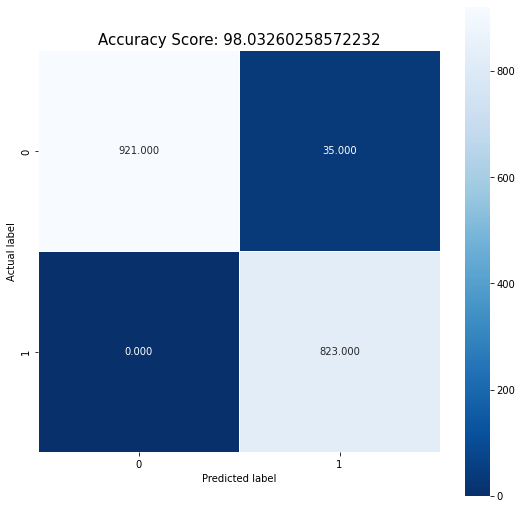

In [19]:
#Confusion Matrix

treeMat = confusion_matrix(y_test, treePred)

plt.figure(figsize=(9,9))
sns.heatmap(treeMat, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {}'.format(treeAcc*100)
plt.title(all_sample_title, size = 15);

In [20]:
#Getting feature importance
#https://machinelearningmastery.com/calculate-feature-importance-with-python/


#Feature importance is calculated by mapping individual features with output variable

importance = tree.feature_importances_
# summarize feature importance
important_features_dict = {}
for idx, val in enumerate(importance):
    important_features_dict[idx] = val

sorted_dict = {k: v for k, v in sorted(important_features_dict.items(), key=lambda item: item[1],reverse=True)}
"""
sorted_value_index = np.argsort(important_features_dict.values())
dictionary_keys = list(important_features_dict.keys())
sorted_dict = {dictionary_keys[i]: sorted(
    important_features_dict.values(),reverse=True)[i] for i in range(len(dictionary_keys))}
print(sorted_dict)
"""
print(sorted_dict)

{1: 0.4601582550794314, 6: 0.20935139269041003, 7: 0.1551932857307709, 0: 0.02539211924754935, 17: 0.022277820968694764, 2: 0.019352475233652265, 15: 0.014870606820105003, 4: 0.01447648257162803, 10: 0.014319829441197614, 12: 0.013027242467355727, 3: 0.011920777019543253, 18: 0.009679351958138351, 8: 0.008927403865857046, 5: 0.008269196270553279, 13: 0.005398793254813578, 9: 0.004065090313836279, 16: 0.0033198770664630652, 11: 0.0, 14: 0.0}


In [21]:
print(X.columns)
tree.feature_importances_

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'sugar_type', 'body_type',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


array([0.02539212, 0.46015826, 0.01935248, 0.01192078, 0.01447648,
       0.0082692 , 0.20935139, 0.15519329, 0.0089274 , 0.00406509,
       0.01431983, 0.        , 0.01302724, 0.00539879, 0.        ,
       0.01487061, 0.00331988, 0.02227782, 0.00967935])

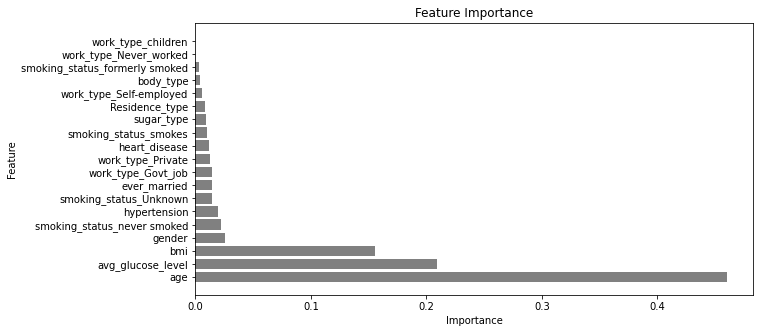

In [22]:
#Drawing horizontal bar graph for showing feature importance

feas = list(sorted_dict.keys())
vals = list(sorted_dict.values())
features = []
for i in feas:
  features.append(X.columns[i])
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.barh(features, vals, color ='grey')
 
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

Optimal hyperparameter combination: {'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 20}

Mean cross-validated training accuracy score: 0.9574207082918503
0.9673974142776841
Test accuracy: 0.97
Execution time of Random Search (in Seconds): 2.506998062133789



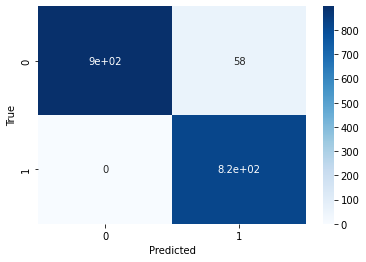

In [23]:
#Trying Hyperparameter tuning to see if we can increase the performance
#https://www.tutorialspoint.com/scikit_learn/scikit_learn_decision_trees.htm
#https://towardsdatascience.com/python-implementation-of-grid-search-and-random-search-for-hyperparameter-optimization-2d6a82ebf75c
#Learned about Decision Tree Classifier
import time
start = time.time()

# Defining 3-dimensional hyperparameter space as a Python dictionary
hyperparameter_space = {'max_depth':[2,5,10,20], 
                        'min_samples_leaf':[3,7,11,16,20,27,25,40],
                        'min_samples_split':[2,3,4,5,6,8,10]}

from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(tree, param_distributions=hyperparameter_space,
                        n_iter=10, scoring="accuracy", random_state=0,
                        n_jobs=-1, cv=10, return_train_score=True)

#cv = Cross Validation
#n_jobs = cpu core
#scoring = accuracy/f1

rs.fit(X_train, y_train)
print("Optimal hyperparameter combination:", rs.best_params_)
print()
print("Mean cross-validated training accuracy score:",
      rs.best_score_)
best_tree = rs.best_estimator_.fit(X_train, y_train)
y_pred = best_tree.predict(X_test) # Predictions
y_true = y_test # True values

tuned = accuracy_score(y_true, y_pred)
print(tuned)
print("Test accuracy:", np.round(tuned, 2))
cf_matrix = confusion_matrix(y_true, y_pred)
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

end = time.time()
diff = end - start
print('Execution time of Random Search (in Seconds):', diff)
print()

In [24]:
from prettytable import PrettyTable
PTables = PrettyTable()

PTables = PrettyTable()
PTables.field_names = ["MODEL.","Accuracy"]
PTables.add_row(["Logistic Regression",np.round(BaseAcc,2)])
PTables.add_row(["DecisionTreeClassifier",np.round(treeAcc,2)])
PTables.add_row(["DecisionTreeClassifier with Tuning",np.round(tuned,2)])
print(PTables)

+------------------------------------+----------+
|               MODEL.               | Accuracy |
+------------------------------------+----------+
|        Logistic Regression         |   0.78   |
|       DecisionTreeClassifier       |   0.98   |
| DecisionTreeClassifier with Tuning |   0.97   |
+------------------------------------+----------+


## Pickling
### Pickling the model(converting it into byte stream) so that we can store it and load it,we don't have to train it another time.

In [25]:
pickle.dump(best_tree,open("decision_tree_model",'wb'))

In [26]:
loaded_model = pickle.load(open("decision_tree_model",'rb'))

In [27]:
y_pred = loaded_model.predict(X_test)
y_true = y_test
accuracy_score(y_true, y_pred)

0.9673974142776841